<a href="https://colab.research.google.com/github/JairEsc/Mat_Apl_2/blob/main/ML_Neumonia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt


Después de cargar la base de Kaggle en Drive, y después de montar esta cuenta de Drive en Colab, tenemos acceso a las imágenes.

Iniciamos el tratamiento de los datos haciendo un resize() para "homogeneizar" los tamaños de las imágenes.

In [2]:
from os import listdir

def loadImages(path):
    # return array of images

    imagesList = listdir(path)
    loadedImages = []
    for image in imagesList:
        img = cv2.imread(path + image)
        loadedImages.append(cv2.resize(img,(300,300)))

    return np.array(loadedImages)

path = "/content/drive/MyDrive/test/NORMAL/"

# your images in an array
test_normales = loadImages("/content/drive/MyDrive/test/NORMAL/")
test_neumonia= loadImages("/content/drive/MyDrive/test/PNEUMONIA/")
train_normales = loadImages("/content/drive/MyDrive/train/NORMAL/")
train_neumonia= loadImages("/content/drive/MyDrive/train/PNEUMONIA/")
val_normales = loadImages("/content/drive/MyDrive/val/NORMAL/")
val_neumonia= loadImages("/content/drive/MyDrive/val/PNEUMONIA/")


Concatenamos las imágenes de cada clase.

In [ ]:
full_test=np.concatenate((test_normales, test_neumonia), axis=0)
full_train=np.concatenate((train_normales, train_neumonia), axis=0)
full_val=np.concatenate((val_normales, val_neumonia), axis=0)


In [ ]:
from keras import layers
from keras import models
convNN = models.Sequential()

Definimos las etiquetas de cada clase que se usarán en el entrenamiento de la red.

In [ ]:
from keras.utils import to_categorical
train_labels = to_categorical(np.repeat((0,1),(len(train_normales),len(train_neumonia))))
test_labels = to_categorical(np.repeat((0,1),(len(test_normales),len(test_neumonia))))
val_labels = to_categorical(np.repeat((0,1),(len(val_normales),len(val_neumonia))))


Utilizamos una función para describir la composición de una Red.

In [ ]:
def resumen(model=None):
    '''
    '''
    header = '{:4} {:16} {:24} {:24} {:10}'.format('#', 'Layer Name','Layer Input Shape','Layer Output Shape','Parameters'
    )
    print('='*(len(header)))
    print(header)
    print('='*(len(header)))
    count=0
    count_trainable=0
    for i, layer in enumerate(model.layers):
        count_trainable += layer.count_params() if layer.trainable else 0
        input_shape = '{}'.format(layer.input_shape)
        output_shape = '{}'.format(layer.output_shape)
        str = '{:<4d} {:16} {:24} {:24} {:10}'.format(i,layer.name, input_shape, output_shape, layer.count_params())
        print(str)
        count += layer.count_params()
    print('_'*(len(header)))
    print('Total Parameters : ', count)
    print('Total Trainable Parameters : ', count_trainable)
    print('Total No-Trainable Parameters : ', count-count_trainable)
    

En este trabajo utilizaremos *EfficientNetB3* por tener una cantidad "pequeña" de parámetros.

In [ ]:
from keras.applications import EfficientNetB3 

Efficient = EfficientNetB3 (weights='imagenet',
                  include_top=True,
                  input_shape=(300, 300, 3))

resumen(Efficient)

#    Layer Name       Layer Input Shape        Layer Output Shape       Parameters
0    input_1          [(None, 300, 300, 3)]    [(None, 300, 300, 3)]             0
1    rescaling        (None, 300, 300, 3)      (None, 300, 300, 3)               0
2    normalization    (None, 300, 300, 3)      (None, 300, 300, 3)               7
3    tf.math.truediv  (None, 300, 300, 3)      (None, 300, 300, 3)               0
4    stem_conv_pad    (None, 300, 300, 3)      (None, 301, 301, 3)               0
5    stem_conv        (None, 301, 301, 3)      (None, 150, 150, 40)           1080
6    stem_bn          (None, 150, 150, 40)     (None, 150, 150, 40)            160
7    stem_activation  (None, 150, 150, 40)     (None, 150, 150, 40)              0
8    block1a_dwconv   (None, 150, 150, 40)     (None, 150, 150, 40)            360
9    block1a_bn       (None, 150, 150, 40)     (None, 150, 150, 40)            160
10   block1a_activation (None, 150, 150, 40)     (None, 150, 150, 40)              0
11

Observamos que hay 12 millones de parámetros, y la red recibe un input de dimensiones (300,300,3). I.e. una imagen de 300$\times$300 con 3 canales.

Definimos lo que será nuestra parte convolucional, definida por las primeras capas de EfficientNetB3.

In [ ]:
Efficient=None 
if Efficient != None:
    del Efficient
    
from keras.applications import EfficientNetB3

conv_base = EfficientNetB3(weights='imagenet',
                  include_top=False,
                  input_shape=(300, 300, 3))
    
resumen(conv_base)   

#    Layer Name       Layer Input Shape        Layer Output Shape       Parameters
0    input_2          [(None, 300, 300, 3)]    [(None, 300, 300, 3)]             0
1    rescaling_1      (None, 300, 300, 3)      (None, 300, 300, 3)               0
2    normalization_1  (None, 300, 300, 3)      (None, 300, 300, 3)               7
3    tf.math.truediv_1 (None, 300, 300, 3)      (None, 300, 300, 3)               0
4    stem_conv_pad    (None, 300, 300, 3)      (None, 301, 301, 3)               0
5    stem_conv        (None, 301, 301, 3)      (None, 150, 150, 40)           1080
6    stem_bn          (None, 150, 150, 40)     (None, 150, 150, 40)            160
7    stem_activation  (None, 150, 150, 40)     (None, 150, 150, 40)              0
8    block1a_dwconv   (None, 150, 150, 40)     (None, 150, 150, 40)            360
9    block1a_bn       (None, 150, 150, 40)     (None, 150, 150, 40)            160
10   block1a_activation (None, 150, 150, 40)     (None, 150, 150, 40)              0
1

Esta parte tiene 10 millones de parámetros, y tiene un output de (10$\times$10$\times$1536).

A continuación se describe brevemente el procedimiento de entrenamiento.



*   Congelamos las capas convolucionales heredadas por EfficientnetB3. De esta manera, los pesos de esta red se mantienen fijos, pues la transferencia de conocimientos supone que estos pesos extraen las características de las imagenes que se ingresan.
*   Agregamos capas entranables a nuestro modelo. Agregamos capas convolucionales y densas, en este caso la primera capa debe recibir como input una imagen que coincida con la capa de salida de la parte convolucional heredada. Como se mencionó antes, de (10$\times$10$\times$1536). Pero esto lo hace automáticamente keras.
*   Hasta ahora, tenemos una cantidad mucho menor de parámetros, que corresponden a los pesos de las capas que sí son entrenables. 
*   Procedemos a entrenar la red. De hecho, como las capas iniciales siguen congeladas, los únicos pesos que se modificarán, serán correspondientes a las capas que agregamos al final.

In [ ]:
model = models.Sequential()

conv_base.trainable = False

model.add(conv_base)   


In [ ]:
model.add(layers.MaxPooling2D(pool_size=(2, 2)))#4/2
model.add(layers.Conv2D(filters     = 64, 
                        kernel_size = (3, 3), 
                        activation  = 'relu' ))
model.add(layers.Flatten())
model.add(layers.Dense(256, 
                        activation='relu'))
model.add(layers.Dense(64, 
                        activation='relu'))
model.add(layers.Dense(2, 
                        activation='softmax'))

In [ ]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 10, 10, 1536)     10783535  
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 5, 5, 1536)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 3, 3, 64)          884800    
                                                                 
 flatten_6 (Flatten)         (None, 576)               0         
                                                                 
 dense_18 (Dense)            (None, 256)               147712    
                                                                 
 dense_19 (Dense)            (None, 64)                16448     
                                                      

Notemos que solamente hay 1,049,090 parámetros entrenables. Procedemos a hacer el entrenamiento.

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer="nadam",
              metrics=['acc'])

In [ ]:
import time
tic = time.time()

model.fit(x = full_train, 
           y = train_labels, 
           epochs    =3,
           batch_size=200,
           verbose=2)

print('seconds=', time.time()-tic)

Epoch 1/3
27/27 - 59s - loss: 0.4309 - acc: 0.8401 - 59s/epoch - 2s/step
Epoch 2/3
27/27 - 33s - loss: 0.1348 - acc: 0.9477 - 33s/epoch - 1s/step
Epoch 3/3
27/27 - 33s - loss: 0.0850 - acc: 0.9701 - 33s/epoch - 1s/step
seconds= 126.66766333580017


Como vemos, tenemos un muy buen desempeño en muy poco tiempo, aprovechando el conocimiento de la red EfficientNetB3.

Aquí, guardaremos nuestra red para reiniciar el entorno de ejecución y liberar memoria RAM.

In [ ]:
#model.save('neumonia_dense_trained.h5')
#from keras.models import load_model
#model = load_model('neumonia_dense_trained.h5')

A continuación, nos gustaría descongelar las capas heredadas de EfficientnetB3, de manera que se mejore el ajuste.
Nota. Fue ejecutado en otro cuaderno de Colab

In [ ]:
model.trainable=True
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 10, 10, 1536)     10783535  
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 5, 5, 1536)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 64)          884800    
                                                                 
 flatten_2 (Flatten)         (None, 576)               0         
                                                                 
 dense_6 (Dense)             (None, 256)               147712    
                                                                 
 dense_7 (Dense)             (None, 64)                16448     
                                                      

In [ ]:
from keras import optimizers
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-5),
              metrics=['acc'])
import time
tic = time.time()

model.fit(x = full_train, 
           y = train_labels, 
           epochs    =3,
           batch_size=20,
           verbose=2)

print('seconds=', time.time()-tic)

Epoch 1/3
261/261 - 213s - loss: 0.1346 - acc: 0.9513 - 213s/epoch - 817ms/step
Epoch 2/3
261/261 - 182s - loss: 0.0648 - acc: 0.9757 - 182s/epoch - 699ms/step
Epoch 3/3
261/261 - 182s - loss: 0.0385 - acc: 0.9858 - 182s/epoch - 698ms/step
seconds= 587.0070667266846


Conseguimos un 98$\%$ de accuracy con datos de entrenamiento.

Damos por finalizada la etapa de entrenamiento, veremos el desempeño con los datos de prueba.

In [ ]:
#model.save('neumonia_full_trained.h5')

In [ ]:
import numpy as np

test_predicted_labels = model.predict(full_test)
test_true_labels      = np.argmax(test_labels,axis=1)
test_predicted_labels = np.argmax(test_predicted_labels,axis=1)

20/20 [==============================] - 7s 178ms/step


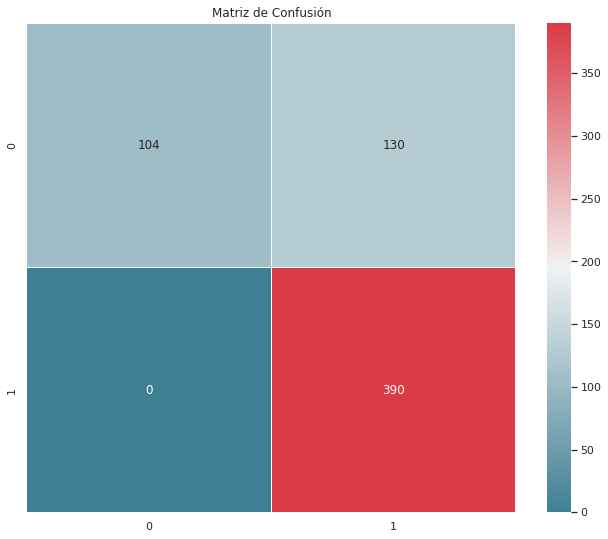

Accuracy: 0.791667
Precision: %f 0.84375
Recall: %f 0.7916666666666666
F1 score: 0.766484
AUC-ROC:  0.7222222222222222


In [ ]:
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score,confusion_matrix, precision_score, recall_score,roc_auc_score

from sklearn.metrics import f1_score, cohen_kappa_score
import seaborn as sns 
C = confusion_matrix(test_true_labels, test_predicted_labels)

f, ax = plt.subplots(figsize=(11, 9))
sns.set()
cmap = sns.diverging_palette(220, 10, as_cmap=True)
ax = sns.heatmap(C, cmap=cmap, square=True,
                 annot=True, fmt='d', linewidths=.5)
ax.set_title('Matriz de Confusión')
plt.show()
accuracy = accuracy_score(test_true_labels, test_predicted_labels)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(test_true_labels, test_predicted_labels,average='weighted')
print('Precision: %f',precision)
# recall: tp / (tp + fn)
recall = recall_score(test_true_labels, test_predicted_labels,average='weighted')
print('Recall: %f' , recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(test_true_labels, test_predicted_labels,average='weighted')
print('F1 score: %f' % f1)
print("AUC-ROC: ",roc_auc_score(test_true_labels,test_predicted_labels))

## Conclusión.

Utilizamos la parte "top" de la EfficientNetB3, que fue entrenada con ImageNet. Congelamos estas capas heredadas y entrenamos únicamente las capas que agregamos a nuestro modelo.

Notamos que el accuracy inicia con valores muy altos desde la primera epoca, lo que era de esperarse pues la transferencia de conocimiento era la intención de este trabajo.
En la segunda parte, descongelamos todas las capas y utilizamos un optimizador de lento aprendizaje, pues se espera que nuestra red ya esté bien ajustada a los datos.

Aunque llegamos a un $98\%$ en la etapa de entrenamiento, y esto fue con muy poco entrenamiento, en la etapa de prueba apenas se llegó a $79\%$. Esto podría ser por sobre-entrenamiento, lo cual es poco probable pues como mencionamos, fue muy poco entrenamiento.